In [1]:
import argparse
import logging
import time

import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer, ngrams_iterator
from torchtext.datasets import DATASETS
from torchtext.prototype.transforms import load_sp_model, PRETRAINED_SP_MODEL, SentencePieceTokenizer
from torchtext.utils import download_from_url
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import FastText, GloVe
from tqdm import tqdm

### Information
- torchtext repo: https://github.com/pytorch/text/tree/main/torchtext
- torchtext documentation: https://pytorch.org/text/stable/index.html

Fill in the code below to make both the CNN1d and CNN2d model work. They should be equivalent.

In [2]:
FILL_IN = "FILL IN"

### Constants

In [3]:
DATASET = "AG_NEWS"
DATA_DIR = ".data"
DEVICE = "mps"
EMBED_DIM = 300
LR = 4.0
BATCH_SIZE = 16
NUM_EPOCHS = 5
PADDING_VALUE = 0
PADDING_IDX = PADDING_VALUE

### Get the tokenizer
- Use the WordLevel tokenizer.


In [4]:
basic_english_tokenizer = get_tokenizer("basic_english")

In [5]:
basic_english_tokenizer("This is some text ...")

['this', 'is', 'some', 'text', '.', '.', '.']

In [6]:
# Needed later.
TOKENIZER = basic_english_tokenizer

### Get the data and get the vocabulary

In [7]:
def yield_tokens(data_iter):
    token_text = []
    for _, text in data_iter:
        # Return the tokenized text.
        # text is a string above.
        token_text.append(TOKENIZER(text))
    return token_text

In [8]:
train_iter = DATASETS[DATASET](root=DATA_DIR, split="train")
# Build the vocabulary, adding two special tokens. One for <pad> and another <unk>.
VOCAB = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<pad>', '<unk>'])

# Make the default index the same as that of the unk_token.
VOCAB.set_default_index(VOCAB['<unk>'])

### Get FastText embeddings

In [9]:
# Get the FastText and CharNGram embeddings from torchtext.
FAST_TEXT = FastText()
GLOVE = GloVe()

In [10]:
GLOVE['man']

tensor([-1.7310e-01,  2.0663e-01,  1.6543e-02, -3.1026e-01,  1.9719e-02,
         2.7791e-01,  1.2283e-01, -2.6328e-01,  1.2522e-01,  3.1894e+00,
        -1.6291e-01, -8.8759e-02,  3.3067e-03, -2.9483e-03, -3.4398e-01,
         1.2779e-01, -9.4536e-02,  4.3467e-01,  4.9742e-01,  2.5068e-01,
        -2.0901e-01, -5.8931e-01,  6.1615e-02,  1.0434e-01,  2.4424e-01,
        -2.9120e-01,  3.0746e-01,  3.6276e-01,  7.1151e-01, -8.0523e-02,
        -5.9524e-01,  3.4834e-01, -3.3048e-01,  7.0316e-02,  5.3329e-01,
        -2.9081e-01,  1.3459e-01, -3.9856e-01, -3.2435e-01,  1.1867e-01,
        -1.4938e-01, -3.8256e-01,  3.3116e-01, -3.1488e-01, -9.4491e-02,
        -6.1319e-02,  1.5518e-01, -2.5523e-01, -1.1813e-01,  2.5296e-01,
        -9.5174e-02, -1.6596e-01, -1.0840e-01,  8.8803e-02,  2.0890e-01,
         4.3981e-01,  1.0476e-03, -4.0666e-02,  2.6487e-01, -6.1009e-01,
        -1.4405e-01, -8.1185e-02,  7.5475e-03,  2.3373e-01, -2.7772e-02,
        -2.9315e-01, -1.1744e-01, -8.3193e-02, -2.3

In [11]:
FAST_TEXT['man']

tensor([-1.1586e-02, -7.6437e-02, -2.4990e-01,  2.8163e-02, -3.5323e-01,
         1.5216e-03, -2.0837e-02, -7.6733e-02,  2.2877e-01,  1.8065e-01,
         3.8324e-01,  3.9388e-01,  1.9390e-01, -6.7518e-02, -1.9435e-02,
        -3.3318e-01, -4.1170e-01,  9.2621e-02, -8.2841e-03,  1.6280e-01,
        -1.0092e-01, -1.8395e-01, -2.4474e-01, -2.0096e-01,  1.7002e-01,
         1.0390e-01, -1.6293e-01, -3.5478e-02,  6.1456e-02, -5.2501e-02,
         3.6431e-02,  3.8296e-01, -2.0610e-01,  9.0258e-03, -3.0089e-02,
        -4.6130e-01,  1.5610e-01, -7.4393e-02,  5.5539e-02,  2.7400e-01,
         1.0643e-01, -2.2214e-01,  8.2432e-02, -1.7137e-01, -1.0055e-01,
        -2.4462e-01, -2.5799e-01, -1.0788e-01,  5.8723e-02,  3.8408e-02,
        -2.5064e-01,  1.6206e-01,  9.0334e-02, -9.7423e-02, -1.2217e-01,
        -8.5929e-02,  3.1295e-01,  1.5443e-01,  3.8319e-01,  2.7565e-02,
         2.9553e-01, -1.0904e-01,  1.7643e-01,  2.4874e-01, -2.3022e-01,
        -2.8496e-02,  1.4229e-01,  4.2295e-02,  2.6

In [12]:
# How many tokens does FAST_TEXT have? How many dimensios per word embedding?
print(FAST_TEXT.vectors.shape)

torch.Size([2519370, 300])


In [13]:
# Same for CHAR_N_GRAM
print(GLOVE.vectors.shape)

torch.Size([2196017, 300])


### Helper functions

In [14]:
def text_pipeline(text):
    # Return a tokenized and int version of the string text.
    # This should work like text="some sentence" -> [0, 1] where "some" is 0 and "sentence" is 1 in the VOCAB.
    return [VOCAB[token] for token in TOKENIZER(text)]

# Return a int version of the label, mapping {1-> 0, 2->1, etc}
def label_pipeline(label):
    return int(label) - 1

Nice link on collate_fn and DataLoader in PyTorch: https://python.plainenglish.io/understanding-collate-fn-in-pytorch-f9d1742647d3

In [15]:
# What does this do?
# How can this be improved?
# This should take a batch of data and return 2 tensors.
# One sentor is a label tensor.
# Another is a padded version of the text.
# I.e. label_list should be [0, 1, 2]
# text_list might be [[1,2,3,4], [1, 2, 0, 0], [6,7,8,0]]
# Note that the first text was length 4, the next length 2, and the last length 3.
# Padding is necessary since tensors cannot have different lengths in a multidimensional tensor.
# This is not the only way, ideally you'd have minimal padding per batch. Don't worry about that.
def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text))
        text_list.append(processed_text)
    
    label_list = torch.tensor(label_list)
    # Make sure you use pad_sequence and use batch first.
    text_list = pad_sequence(text_list, batch_first=True, padding_value=PADDING_VALUE)
            
    return label_list.to(DEVICE), text_list.to(DEVICE)

### Get the data

In [16]:
train_iter = DATASETS[DATASET](root=DATA_DIR, split="train")
num_class = len(set([label for (label, text) in train_iter]))
# What are the classes?
print(f"The number of classes is {num_class} ...")

The number of classes is 4 ...


### Set up the model

Good reference on this type of model
- CNN for Sentence Classification: https://arxiv.org/pdf/1408.5882.pdf

You can build CNN models with either CNN1d or CNN2d.

In [17]:
# Data is of 128 word vector dimension and contains 10 words.
fake_sentence = torch.randn(128, 10)

# Build a 1d kernel which has 128 in channels and 1 out channels and a kernel size of 2.
# The number of word vector dimensions is 128.
# There is no padding here - what is the word dimension?
# Should be [1, 9].
print(torch.nn.Conv1d(128, 1, 2)(fake_sentence).shape)

# Do the same thing using a 2d kernel. Use 1 in channel, 1 out
# Make the filter size so that it's equivalent to the above.
# You might need to unsqueeze(0) here on fake_sentence - Conv2d wants a box, an "image". 
# Note that text = image with 1 channel.
# Should be [1, 1, 9].
print(torch.nn.Conv2d(1, 1, (128, 2))(fake_sentence.unsqueeze(0)).shape)

torch.Size([1, 9])
torch.Size([1, 1, 9])


This is just a nice picture to recall what is going on here.

This shows 4 filters, of sizes 2 and 3. We will use 3 filters.

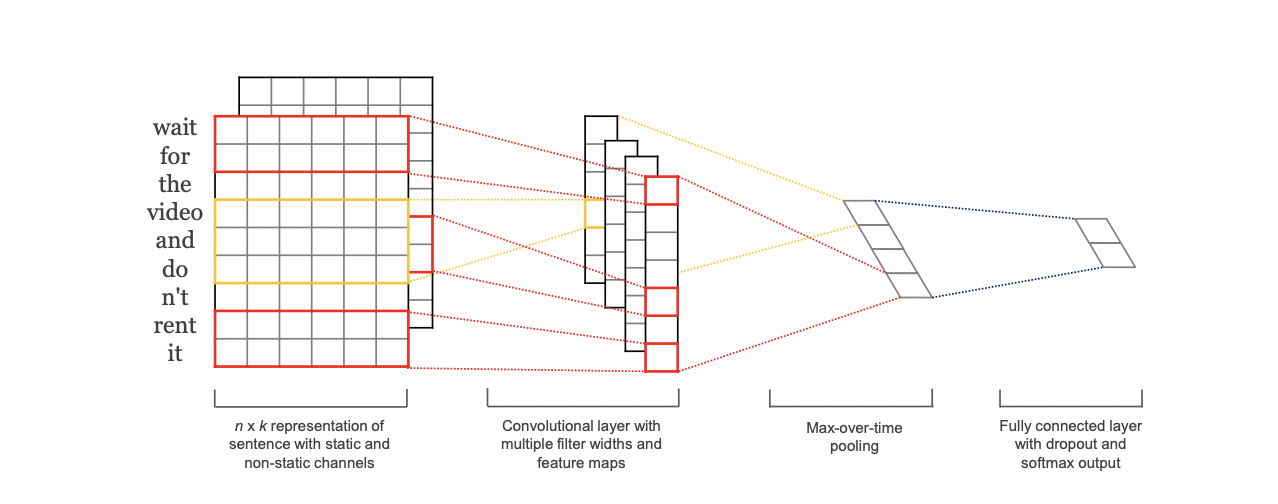

In [18]:
# If you want to use the CharNGram 100 dimensional embeddings, you need to modif the below code.
class CNN1dTextClassificationModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_class,
        embed_dim = 300, 
        use_pretrained = True,
        fine_tune_embeddings = True
    ):
        
        super(CNN1dTextClassificationModel, self).__init__()
        
        self.embedding = nn.Embedding(
            vocab_size,
            embed_dim,
            padding_idx=PADDING_IDX
        )
        
        if use_pretrained:
            self.embedding.weight.requires_grad = False
            for i in range(vocab_size):
                # Get the token for the index i.
                token = VOCAB.get_itos()[i]
                
                # Get the embedding for the token and put it in index i.
                self.embedding.weight[i, :] = FAST_TEXT[token]
            self.embedding.weight.requires_grad = True
        else:
            self.init_weights()
                
        if not fine_tune_embeddings:
            self.embedding.weight.requires_grad = False
        
        
        # Set up 3 Conv1d layers. Use kernel size 2, 3, 4.
        # There is only 1 filter for each kernel size.
        self.cnn2 = torch.nn.Conv1d(embed_dim, 1, 2)
        self.cnn3 = torch.nn.Conv1d(embed_dim, 1, 3)
        self.cnn4 = torch.nn.Conv1d(embed_dim, 1, 4)
        
        # This should be linear mapping to the number of output classes.
        self.fc = nn.Linear(3, num_class)
        
        # For drop out + ReLu, order does not matter.
        # Use 0.3
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        
        # Set to True at first, then set to False.
        self.debug = True
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    # N = batch_size, L = sequence length, D = embed_dim
    def forward(self, text):
        
        # N X L X embed_dim
        embedded = self.embedding(text)
        
        if self.debug:
            print('embedding', embedded.shape)
        
        # N X embed_dim X L
        # Here we need to transpose because conv takes data with embed_dim number of channels.
        embedded = embedded.transpose(1, 2)
        
        # Apply the filters, then ReLU.
        
        # N X 1 X L - 1
        cnn2 = self.cnn2(embedded)
        if self.debug:
            print('cnn2', cnn2.shape)
        
        # N X 1 X L - 2
        cnn3 = self.cnn3(embedded)
        if self.debug:
            print('cnn3', cnn3.shape)
        
        # N X 1 X L - 3
        cnn4 = self.cnn4(embedded)
        if self.debug:
            print('cnn4', cnn4.shape)
        
        # N X 1 in all cases. Fun each filter through a max pooling layer.
        cnn2 = nn.MaxPool1d((cnn2.shape[2]))(cnn2)
        cnn3 = nn.MaxPool1d((cnn3.shape[2]))(cnn3)
        cnn4 = nn.MaxPool1d((cnn4.shape[2]))(cnn4)
        if self.debug:
            print('cnn2 after max', cnn2.shape)
        
        # N X 3
        # Concatenate these, and apply dropout.
        cnn_concat = torch.cat((cnn2, cnn3, cnn4), dim=1).squeeze(2)
        if self.debug:
            print('cnn concat', cnn_concat.shape)
        
        # Use fc to map to the output number.
        out = self.fc(self.relu(self.dropout(cnn_concat)))
        
        # Set this to False after going through one batch od data.
        self.debug = False
        
        return out
    
# If you want to use the CharNGram 100 dimensional embeddings, you need to modif the below code.
# For CNN2d the data should be of shape B X 1 X embed_dim X L instead of B X embed_dim X L .
# This is since the "channel" is 1 dimensional.
class CNN2dTextClassificationModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_class,
        embed_dim = 300, 
        use_pretrained = False,
        fine_tune_embeddings = True
    ):
        
        super(CNN2dTextClassificationModel, self).__init__()
        
        self.embedding = nn.Embedding(
            vocab_size,
            embed_dim,
            padding_idx=PADDING_IDX
        )
        
        if use_pretrained:
            self.embedding.weight.requires_grad = False
            for i in range(vocab_size):
                token = VOCAB.get_itos()[i]
                
                self.embedding.weight[i, :] = FAST_TEXT[token]
            self.embedding.weight.requires_grad = True
        else:
            self.init_weights()
                
        if not fine_tune_embeddings:
            self.embedding.weight.requires_grad = False
        
        # In C X H X W "image", we have C = 1, H = embed_dim, W = k for text.
        # We can also swap H and W but this is to make this "look" like the case when we do 1d convolutions.
        self.convs = torch.nn.ModuleList([nn.Conv2d(1, 1, (embed_dim, 2)),
                      nn.Conv2d(1, 1, (embed_dim, 3)),
                      nn.Conv2d(1, 1, (embed_dim, 4))
                     ])
        
        self.fc = nn.Linear(3, num_class)
        
        # For drop out + ReLu, order does not matter.
        self.dropout = nn.Sequential(
            nn.Dropout(0.3),
            nn.ReLU()
        )
        
        self.relu = nn.ReLU()
        
        self.debug = True
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    # B = batch_size, L = sequence length, D = vector dimension
    def forward(self, text):
        # text is originally N X L
        
        # N X L X embed_dim
        embedded = self.embedding(text)
        
        if self.debug:
            print('embedded ', embedded.shape)
        
        # N X embed_dim X L
        embedded = embedded.transpose(1, 2)
        
        if self.debug:
            print('embedded ', embedded.shape)
        
        # This is N X 1 X (L - k + 1), where k is the filter size.
        # We need to add a dimension to "embedded".
        # Use loop comprehension - no need to parrallelize.
        # Apply each conv to embedded and also do a ReLU. 
        embedded_temp = embedded.unsqueeze(1)
        convs = [self.relu((conv(embedded_temp).squeeze(1))) for conv in self.convs]
        
        if self.debug:
            print('conv ', [conv.shape for conv in convs])
        
        # Across all time steps. This is a list and each is dimension 3.
        # Use loop comprehension.
        maxes = [nn.MaxPool1d(conv.shape[-1])(conv).squeeze(-1) for conv in convs]
        
        if self.debug:
            print('max ', [conv_max.shape for conv_max in maxes])
        
        # N X 3
        maxes_stack = torch.cat(maxes, dim=-1)
        
        if self.debug:
            print('max_stack ', maxes_stack.shape)
            
                        
        out = self.fc(self.dropout(maxes_stack))
        
        # Set to False after the first batch goes through.
        self.debug = False
        
        return out

### Set up the model

In [19]:
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
# Conv1d model.
model1 = CNN1dTextClassificationModel(len(VOCAB), num_class, use_pretrained=True, fine_tune_embeddings=True)


### Set the model to either the CNN1d or the CNN2d model

In [20]:
model = model1.to(DEVICE)

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

### Set up the data

In [19]:
train_iter, test_iter = DATASETS[DATASET]()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# Build a DataLoader in each base. Make sure you pass in the batch size and collate_batch.
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

### Train the model

In [20]:
def train(dataloader, model, optimizer, criterion, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 1000

    for idx, (label, text) in tqdm(enumerate(dataloader), total=len(dataloader), mininterval=3):
        # QUESTION: You need to do something here with the optimizer, for each batch. What?
        # HINT: Not .step.
        optimizer.zero_grad()
        predicted_label = model(text)
                
        # Get the loss.
        loss = criterion(predicted_label, label)
        
        # Do back propagation.
        loss.backward()
        
        # Clip the gradients at 0.1.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Do an optimization step.
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(epoch, idx, len(dataloader), total_acc / total_count)
            )
            total_acc, total_count = 0, 0

In [21]:
def evaluate(dataloader, model):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predited_label = model(text)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [25]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, model, optimizer, criterion, epoch)
    accu_val = evaluate(valid_dataloader, model)
    scheduler.step()
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(epoch, time.time() - epoch_start_time, accu_val)
    )
    print("-" * 59)

print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader, model)
print("test accuracy {:8.3f}".format(accu_test))

  0%|          | 0/7125 [00:00<?, ?it/s]

embedding torch.Size([16, 79, 300])
cnn2 torch.Size([16, 1, 78])
cnn3 torch.Size([16, 1, 77])
cnn4 torch.Size([16, 1, 76])
cnn2 after max torch.Size([16, 1, 1])
cnn concat torch.Size([16, 3])


 14%|█▍        | 1001/7125 [00:52<05:09, 19.79it/s]

| epoch   1 |  1000/ 7125 batches | accuracy    0.572


 28%|██▊       | 1979/7125 [01:42<04:23, 19.51it/s]

| epoch   1 |  2000/ 7125 batches | accuracy    0.649


 42%|████▏     | 2989/7125 [02:35<03:42, 18.56it/s]

| epoch   1 |  3000/ 7125 batches | accuracy    0.663


 55%|█████▌    | 3950/7125 [03:25<02:46, 19.06it/s]

| epoch   1 |  4000/ 7125 batches | accuracy    0.658


 70%|██████▉   | 4955/7125 [04:18<01:53, 19.13it/s]

| epoch   1 |  5000/ 7125 batches | accuracy    0.670


 84%|████████▎ | 5962/7125 [05:11<01:00, 19.13it/s]

| epoch   1 |  6000/ 7125 batches | accuracy    0.669


 98%|█████████▊| 6974/7125 [06:03<00:07, 19.78it/s]

| epoch   1 |  7000/ 7125 batches | accuracy    0.664


100%|██████████| 7125/7125 [06:11<00:00, 19.18it/s]


-----------------------------------------------------------
| end of epoch   1 | time: 373.09s | valid accuracy    0.812 
-----------------------------------------------------------


 14%|█▎        | 967/7125 [00:49<05:14, 19.57it/s]

| epoch   2 |  1000/ 7125 batches | accuracy    0.681


 28%|██▊       | 1987/7125 [01:42<04:27, 19.20it/s]

| epoch   2 |  2000/ 7125 batches | accuracy    0.695


 42%|████▏     | 2981/7125 [02:34<03:43, 18.57it/s]

| epoch   2 |  3000/ 7125 batches | accuracy    0.692


 56%|█████▌    | 3998/7125 [03:27<02:45, 18.91it/s]

| epoch   2 |  4000/ 7125 batches | accuracy    0.689


 70%|██████▉   | 4959/7125 [04:16<01:49, 19.78it/s]

| epoch   2 |  5000/ 7125 batches | accuracy    0.692


 84%|████████▍ | 5976/7125 [05:10<01:00, 19.05it/s]

| epoch   2 |  6000/ 7125 batches | accuracy    0.696


 98%|█████████▊| 7000/7125 [06:02<00:06, 20.00it/s]

| epoch   2 |  7000/ 7125 batches | accuracy    0.697


100%|██████████| 7125/7125 [06:08<00:00, 19.32it/s]


-----------------------------------------------------------
| end of epoch   2 | time: 370.29s | valid accuracy    0.859 
-----------------------------------------------------------


 14%|█▎        | 967/7125 [00:49<05:14, 19.56it/s]

| epoch   3 |  1000/ 7125 batches | accuracy    0.700


 28%|██▊       | 1976/7125 [01:41<04:28, 19.16it/s]

| epoch   3 |  2000/ 7125 batches | accuracy    0.693


 42%|████▏     | 2967/7125 [02:34<03:45, 18.48it/s]

| epoch   3 |  3000/ 7125 batches | accuracy    0.700


 56%|█████▌    | 3991/7125 [03:27<02:45, 18.99it/s]

| epoch   3 |  4000/ 7125 batches | accuracy    0.697


 70%|██████▉   | 4955/7125 [04:16<01:50, 19.67it/s]

| epoch   3 |  5000/ 7125 batches | accuracy    0.691


 84%|████████▍ | 5973/7125 [05:09<00:59, 19.24it/s]

| epoch   3 |  6000/ 7125 batches | accuracy    0.706


 98%|█████████▊| 6997/7125 [06:02<00:06, 19.94it/s]

| epoch   3 |  7000/ 7125 batches | accuracy    0.700


100%|██████████| 7125/7125 [06:08<00:00, 19.33it/s]


-----------------------------------------------------------
| end of epoch   3 | time: 370.09s | valid accuracy    0.859 
-----------------------------------------------------------


 14%|█▎        | 977/7125 [00:49<05:12, 19.65it/s]

| epoch   4 |  1000/ 7125 batches | accuracy    0.696


 28%|██▊       | 1992/7125 [01:42<04:29, 19.03it/s]

| epoch   4 |  2000/ 7125 batches | accuracy    0.698


 42%|████▏     | 2990/7125 [02:34<03:39, 18.86it/s]

| epoch   4 |  3000/ 7125 batches | accuracy    0.694


 56%|█████▌    | 3962/7125 [03:24<02:45, 19.14it/s]

| epoch   4 |  4000/ 7125 batches | accuracy    0.698


 70%|███████   | 4998/7125 [04:16<01:48, 19.65it/s]

| epoch   4 |  5000/ 7125 batches | accuracy    0.702


 84%|████████▎ | 5958/7125 [05:06<00:59, 19.56it/s]

| epoch   4 |  6000/ 7125 batches | accuracy    0.706


 98%|█████████▊| 6986/7125 [05:58<00:06, 20.07it/s]

| epoch   4 |  7000/ 7125 batches | accuracy    0.701


100%|██████████| 7125/7125 [06:05<00:00, 19.47it/s]


-----------------------------------------------------------
| end of epoch   4 | time: 367.34s | valid accuracy    0.860 
-----------------------------------------------------------


 14%|█▎        | 977/7125 [00:49<05:11, 19.73it/s]

| epoch   5 |  1000/ 7125 batches | accuracy    0.699


 28%|██▊       | 1996/7125 [01:42<04:26, 19.23it/s]

| epoch   5 |  2000/ 7125 batches | accuracy    0.706


 42%|████▏     | 3004/7125 [02:34<03:36, 19.02it/s]

| epoch   5 |  3000/ 7125 batches | accuracy    0.697


 56%|█████▌    | 3974/7125 [03:23<02:42, 19.44it/s]

| epoch   5 |  4000/ 7125 batches | accuracy    0.694


 69%|██████▉   | 4950/7125 [04:13<01:48, 20.02it/s]

| epoch   5 |  5000/ 7125 batches | accuracy    0.697


 84%|████████▍ | 5974/7125 [05:06<00:59, 19.33it/s]

| epoch   5 |  6000/ 7125 batches | accuracy    0.705


 98%|█████████▊| 7003/7125 [05:58<00:06, 20.12it/s]

| epoch   5 |  7000/ 7125 batches | accuracy    0.709


100%|██████████| 7125/7125 [06:04<00:00, 19.53it/s]


-----------------------------------------------------------
| end of epoch   5 | time: 366.28s | valid accuracy    0.860 
-----------------------------------------------------------
Checking the results of test dataset.
test accuracy    0.868


In [22]:
model2 = CNN2dTextClassificationModel(len(VOCAB), num_class, use_pretrained=True, fine_tune_embeddings=True)

In [23]:
# Conv2d model.
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
model = model2.to(DEVICE)

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [25]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, model, optimizer, criterion, epoch)
    accu_val = evaluate(valid_dataloader, model)
    scheduler.step()
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(epoch, time.time() - epoch_start_time, accu_val)
    )
    print("-" * 59)

print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader, model)
print("test accuracy {:8.3f}".format(accu_test))

  0%|          | 0/7125 [00:00<?, ?it/s]

embedded  torch.Size([16, 89, 300])
embedded  torch.Size([16, 300, 89])
conv  [torch.Size([16, 1, 88]), torch.Size([16, 1, 87]), torch.Size([16, 1, 86])]
max  [torch.Size([16, 1]), torch.Size([16, 1]), torch.Size([16, 1])]
max_stack  torch.Size([16, 3])


 14%|█▍        | 995/7125 [00:59<06:09, 16.59it/s]

| epoch   1 |  1000/ 7125 batches | accuracy    0.637


 27%|██▋       | 1956/7125 [01:56<05:12, 16.55it/s]

| epoch   1 |  2000/ 7125 batches | accuracy    0.657


 42%|████▏     | 2967/7125 [02:52<03:59, 17.34it/s]

| epoch   1 |  3000/ 7125 batches | accuracy    0.667


 56%|█████▌    | 3972/7125 [03:44<02:37, 19.96it/s]

| epoch   1 |  4000/ 7125 batches | accuracy    0.663


 70%|███████   | 5005/7125 [04:37<01:47, 19.75it/s]

| epoch   1 |  5000/ 7125 batches | accuracy    0.667


 84%|████████▍ | 5999/7125 [05:30<01:00, 18.51it/s]

| epoch   1 |  6000/ 7125 batches | accuracy    0.670


 98%|█████████▊| 7002/7125 [06:24<00:06, 18.30it/s]

| epoch   1 |  7000/ 7125 batches | accuracy    0.669


100%|██████████| 7125/7125 [06:30<00:00, 18.25it/s]


-----------------------------------------------------------
| end of epoch   1 | time: 393.36s | valid accuracy    0.850 
-----------------------------------------------------------


 14%|█▍        | 1002/7125 [00:52<05:31, 18.49it/s]

| epoch   2 |  1000/ 7125 batches | accuracy    0.691


 28%|██▊       | 1962/7125 [01:45<04:47, 17.97it/s]

| epoch   2 |  2000/ 7125 batches | accuracy    0.685


 42%|████▏     | 2963/7125 [02:38<03:47, 18.27it/s]

| epoch   2 |  3000/ 7125 batches | accuracy    0.690


 55%|█████▌    | 3948/7125 [03:31<02:44, 19.29it/s]

| epoch   2 |  4000/ 7125 batches | accuracy    0.692


 70%|██████▉   | 4980/7125 [04:23<01:47, 19.98it/s]

| epoch   2 |  5000/ 7125 batches | accuracy    0.691


 84%|████████▎ | 5965/7125 [05:16<01:02, 18.58it/s]

| epoch   2 |  6000/ 7125 batches | accuracy    0.696


 98%|█████████▊| 6950/7125 [06:09<00:09, 18.70it/s]

| epoch   2 |  7000/ 7125 batches | accuracy    0.696


100%|██████████| 7125/7125 [06:18<00:00, 18.80it/s]


-----------------------------------------------------------
| end of epoch   2 | time: 381.83s | valid accuracy    0.867 
-----------------------------------------------------------


 14%|█▍        | 993/7125 [00:52<05:26, 18.80it/s]

| epoch   3 |  1000/ 7125 batches | accuracy    0.696


 27%|██▋       | 1956/7125 [01:45<04:50, 17.82it/s]

| epoch   3 |  2000/ 7125 batches | accuracy    0.695


 41%|████▏     | 2951/7125 [02:37<03:40, 18.92it/s]

| epoch   3 |  3000/ 7125 batches | accuracy    0.697


 56%|█████▌    | 4003/7125 [03:33<02:40, 19.42it/s]

| epoch   3 |  4000/ 7125 batches | accuracy    0.694


 70%|██████▉   | 4953/7125 [04:22<01:52, 19.24it/s]

| epoch   3 |  5000/ 7125 batches | accuracy    0.696


 84%|████████▍ | 5979/7125 [05:18<01:02, 18.48it/s]

| epoch   3 |  6000/ 7125 batches | accuracy    0.698


 98%|█████████▊| 6996/7125 [06:14<00:07, 17.78it/s]

| epoch   3 |  7000/ 7125 batches | accuracy    0.700


100%|██████████| 7125/7125 [06:21<00:00, 18.67it/s]


-----------------------------------------------------------
| end of epoch   3 | time: 384.51s | valid accuracy    0.869 
-----------------------------------------------------------


 14%|█▎        | 978/7125 [00:52<05:34, 18.39it/s]

| epoch   4 |  1000/ 7125 batches | accuracy    0.700


 28%|██▊       | 1973/7125 [01:48<04:54, 17.49it/s]

| epoch   4 |  2000/ 7125 batches | accuracy    0.699


 41%|████▏     | 2946/7125 [02:41<03:52, 17.96it/s]

| epoch   4 |  3000/ 7125 batches | accuracy    0.700


 56%|█████▌    | 3987/7125 [03:37<02:42, 19.27it/s]

| epoch   4 |  4000/ 7125 batches | accuracy    0.705


 70%|███████   | 4991/7125 [04:29<01:51, 19.18it/s]

| epoch   4 |  5000/ 7125 batches | accuracy    0.702


 84%|████████▎ | 5965/7125 [05:22<01:02, 18.61it/s]

| epoch   4 |  6000/ 7125 batches | accuracy    0.701


 98%|█████████▊| 6999/7125 [06:18<00:06, 18.13it/s]

| epoch   4 |  7000/ 7125 batches | accuracy    0.705


100%|██████████| 7125/7125 [06:25<00:00, 18.50it/s]


-----------------------------------------------------------
| end of epoch   4 | time: 388.05s | valid accuracy    0.869 
-----------------------------------------------------------


 14%|█▍        | 987/7125 [00:52<05:32, 18.48it/s]

| epoch   5 |  1000/ 7125 batches | accuracy    0.702


 28%|██▊       | 1988/7125 [01:48<04:53, 17.52it/s]

| epoch   5 |  2000/ 7125 batches | accuracy    0.699


 41%|████▏     | 2951/7125 [02:40<03:53, 17.90it/s]

| epoch   5 |  3000/ 7125 batches | accuracy    0.701


 56%|█████▌    | 3995/7125 [03:36<02:42, 19.27it/s]

| epoch   5 |  4000/ 7125 batches | accuracy    0.696


 70%|███████   | 4997/7125 [04:29<01:51, 19.04it/s]

| epoch   5 |  5000/ 7125 batches | accuracy    0.695


 84%|████████▎ | 5965/7125 [05:21<01:02, 18.49it/s]

| epoch   5 |  6000/ 7125 batches | accuracy    0.700


 98%|█████████▊| 6998/7125 [06:18<00:07, 18.09it/s]

| epoch   5 |  7000/ 7125 batches | accuracy    0.695


100%|██████████| 7125/7125 [06:24<00:00, 18.52it/s]


-----------------------------------------------------------
| end of epoch   5 | time: 387.58s | valid accuracy    0.869 
-----------------------------------------------------------
Checking the results of test dataset.
test accuracy    0.869
